# Scraping dynamic website using Selenium

In [ ]:
!pip install selenium --upgrade --quiet

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from datetime import date
from datetime import timedelta
import pandas as pd
import time
import os

### Defining all the functions

In [ ]:
def get_url(date, place):
    url = "https://aertrip.com/flights?return={}&adult=1&child=0&infant=0&trip_type=return&totalLegs=2&origin=BOM&depart={}&destination={}&cabinclass=Economy&nonStopFlag=true&filters%5B0%5D%5Bdep_dt%5D%5B%5D=&filters%5B0%5D%5Bdep_dt%5D%5B%5D=900&filters%5B1%5D%5Bdep_dt%5D%5B%5D=900&filters%5B1%5D%5Bdep_dt%5D%5B%5D=#/searched".format(date, date, place)
    return url

def scroll_bottom():
    SCROLL_PAUSE_TIME = 1
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        
def click_load_all_button():
    buttons_to_loadall = driver.find_elements(By.CLASS_NAME, 'css-total-fl-text')
    for button in buttons_to_loadall:
        try:
            button.click()
        except:
            return
        
def toggle_places():
    toggle_button = driver.find_element(By.CLASS_NAME, 'interchange')
    while True:
        try:
            toggle_button.click()
            break
        except:
            pass

def click_search_button():
    button = driver.find_element(By.CLASS_NAME, 'buttonDiv')
    button.click()
    time.sleep(10)
    
def get_flights():
    flights = driver.find_elements(By.CLASS_NAME, 'departureDetailsBox')
    print(len(flights))
    for i in range(len(flights)):
        flights[i] = flights[i].text.split('\n')
    return flights

def get_df(flights):
    df = pd.DataFrame(columns = ['Origin', 'Destination', 'Company', 'Departure Time', 'Arrival Time', 'Duration Time', 'Flight Price'])
    
    for f in flights:
        origin = f[4][:3]
        destination = f[4][-3:]
        company = f[1].split('-')[0]
        departure_time = f[0]
        arrival_time = f[2]
        if arrival_time[-2:] == '+1':
            arrival_time = arrival_time.split()[0]
        duration_time = f[3]
        flight_price = f[-1]

        df = df.append(
            {
                'Origin': origin,
                'Destination' : destination,
                'Company' : company,
                'Departure Time': departure_time,
                'Arrival Time': arrival_time,
                'Duration Time': duration_time,
                'Flight Price': flight_price
            }, ignore_index = True)
    return df

### Airport codes

In [ ]:
airports = {
    'BOM': 'Mumbai, Chhatrapati Shivaji International Airport', 
    'DEL': 'Delhi, Indira Gandhi International Airport',
    'BLR': 'Bengaluru, Kempegowda International Airport',
    'HYD': 'Hyderabad, Rajiv Gandhi International Airport',
    'CCU': 'Kolkata, Netaji Subhas Chandra Bose Airport',
    'MAA': 'Chennai, Chennai Airport'
}

airport_codes = list(airports.keys())
bom = airport_codes.pop(0)
airport_codes

### Getting the list of dates for which we need the data (modify the code for custom dates)

In [ ]:
list_of_dates = []
today = date.today()
start_date = today + timedelta(days=7)
list_of_dates.append(start_date.strftime('%d-%m-%Y'))
for i in range(15):
    start_date = start_date + timedelta(days=1)
    list_of_dates.append(start_date.strftime('%d-%m-%Y'))
print(list_of_dates)

### Creating directories for storing data

In [ ]:
import os

original = os.getcwd()

for place in airport_codes:
    os.mkdir(place)
    os.chdir(original)

### Main code for scarping

In [ ]:
for place in airport_codes:
    for date in list_of_dates:
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
        url = get_url(date, place)
        print(url)
        driver.get(url)
        driver.maximize_window()
        time.sleep(10)
        while True:
            try:
                WebDriverWait(driver, 10).until(EC.invisibility_of_element_located((By.ID, 'flight-search-loader')))
            except TimeoutException:
                break
        scroll_bottom()
        click_load_all_button()
        StaleElementReferenceExceptionCount = 1
        maxAttempts = 10
        while True:
            try:
                flights = get_flights()
                time.sleep(5)
                break
            except StaleElementReferenceException:
                print('StaleElementReferenceException: ', StaleElementReferenceExceptionCount)
                if StaleElementReferenceExceptionCount == maxAttempts:
                    raise
                StaleElementReferenceExceptionCount += 1
            except StaleElementReferenceException:
                print('StaleElementReferenceException: ', StaleElementReferenceExceptionCount)
                if StaleElementReferenceExceptionCount == maxAttempts:
                    raise
                StaleElementReferenceExceptionCount += 1

        df = get_df(flights)
        toggle_places()
        click_search_button()
        while True:
            try:
                WebDriverWait(driver, 10).until(EC.invisibility_of_element_located((By.ID, 'flight-search-loader')))
            except TimeoutException:
                break
        scroll_bottom()
        click_load_all_button()
        flights = get_flights()
        df1 = get_df(flights)
        df = df.append(df1, ignore_index=True)
        df['Date'] = date
        df['Cabin Class'] = 'Economy'
        df.to_csv(date + '.csv', index=False)


## Scraping dynamic website aertrip using selenium
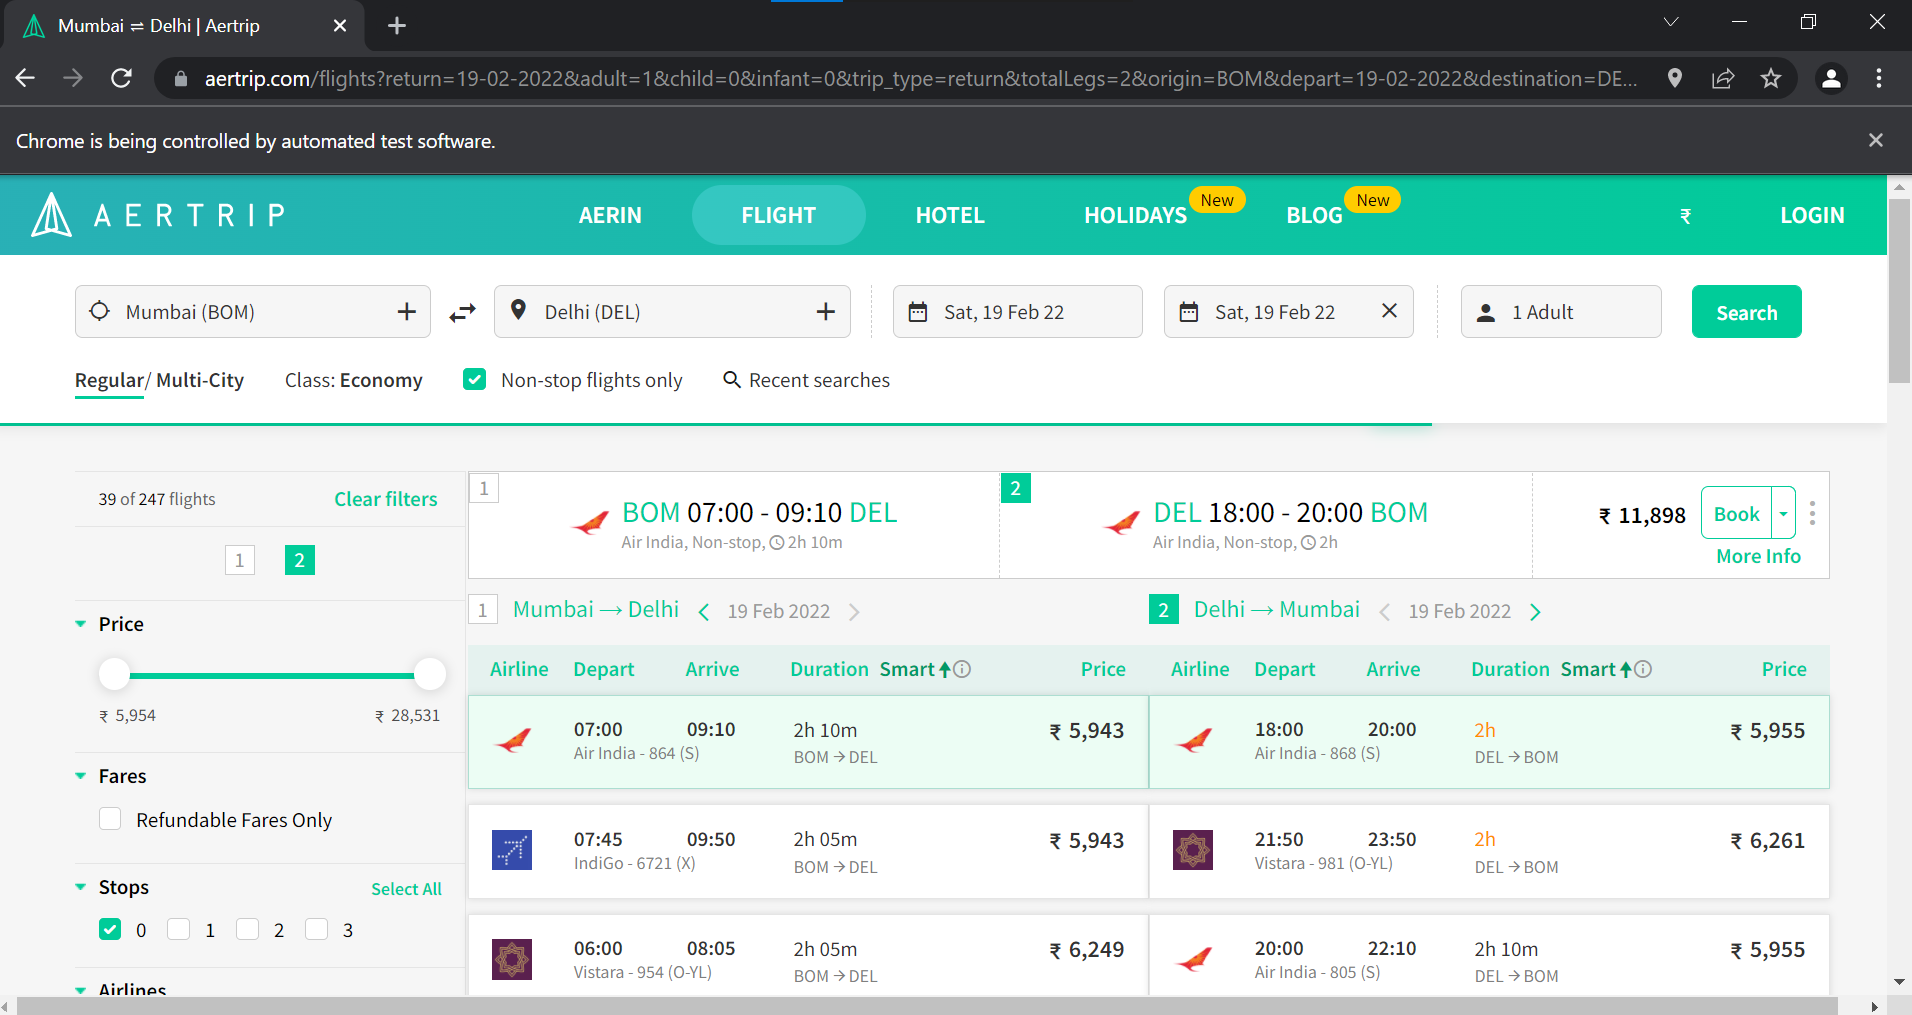

### Storing all the data into a single .csv file

In [ ]:
import os
import pandas as pd

original = os.getcwd()

main_df = pd.DataFrame()

for place in airport_codes:
    os.chdir(place)
    place_df = pd.DataFrame()
    for date in list_of_dates:
        df = pd.read_csv(date + '.csv')
        place_df = place_df.append(df)
    place_df.to_csv(place + '.csv', index=False)
    main_df = main_df.append(place_df)
    os.chdir(original)

main_df.to_csv('data.csv', index=False)